In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard 



# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline


from PIL import Image
from collections import defaultdict

dataset_path = r'C:\Users\Juani\Desktop\train'

# Variables globales
TIPO_IMAGEN = "buildings", "forest", "glacier","mountain","sea","street" 
# configurar de acuerdo a dónde bajaron los sets de imágenes
#TRAIN_DIR = r'C:\Users\Pablo Fontanessi\Desktop\ML\train'
TEST_DIR = r'C:\Users\Juani\Desktop\test'
SIZE = 64



# 1. Análisis exploratorio sobre el conjunto de datos.

## Volumetría de los datos

In [2]:
classes = os.listdir(dataset_path)
image_count = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_count[class_name] = len(os.listdir(class_path))

image_count_df = pd.DataFrame(list(image_count.items()), columns=['Class', 'Image Count'])
print(image_count_df)

total_images = image_count_df['Image Count'].sum()
print(f"\nTotal de imágenes en el dataset: {total_images} \n")

size_distribution = defaultdict(int)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        size_distribution[image.size] += 1

for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

       Class  Image Count
0  buildings         2191
1     forest         2271
2    glacier         2404
3   mountain         2512
4        sea         2274
5     street         2382

Total de imágenes en el dataset: 14034 

Size: (150, 150), Count: 13986
Size: (150, 124), Count: 1
Size: (150, 113), Count: 7
Size: (150, 108), Count: 2
Size: (150, 133), Count: 1
Size: (150, 115), Count: 1
Size: (150, 135), Count: 3
Size: (150, 136), Count: 2
Size: (150, 110), Count: 1
Size: (150, 105), Count: 1
Size: (150, 111), Count: 3
Size: (150, 120), Count: 1
Size: (150, 149), Count: 1
Size: (150, 143), Count: 2
Size: (150, 146), Count: 2
Size: (150, 134), Count: 2
Size: (150, 142), Count: 2
Size: (150, 123), Count: 2
Size: (150, 119), Count: 1
Size: (150, 102), Count: 1
Size: (150, 76), Count: 1
Size: (150, 97), Count: 1
Size: (150, 144), Count: 2
Size: (150, 103), Count: 1
Size: (150, 100), Count: 1
Size: (150, 141), Count: 1
Size: (150, 145), Count: 1
Size: (150, 81), Count: 1
Size: (150, 147), C

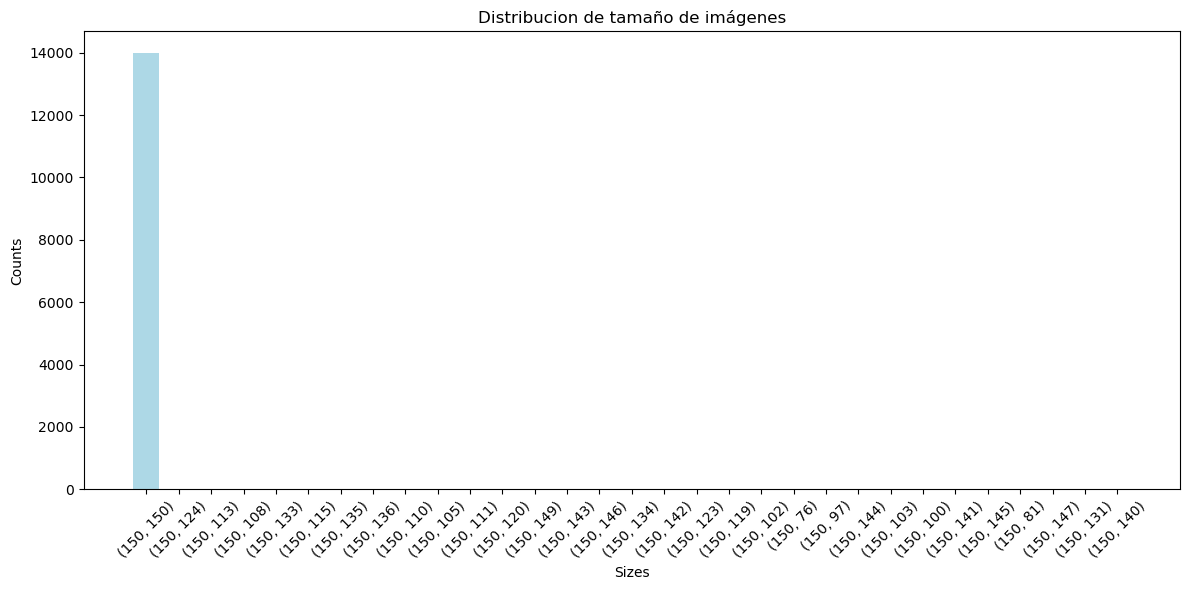

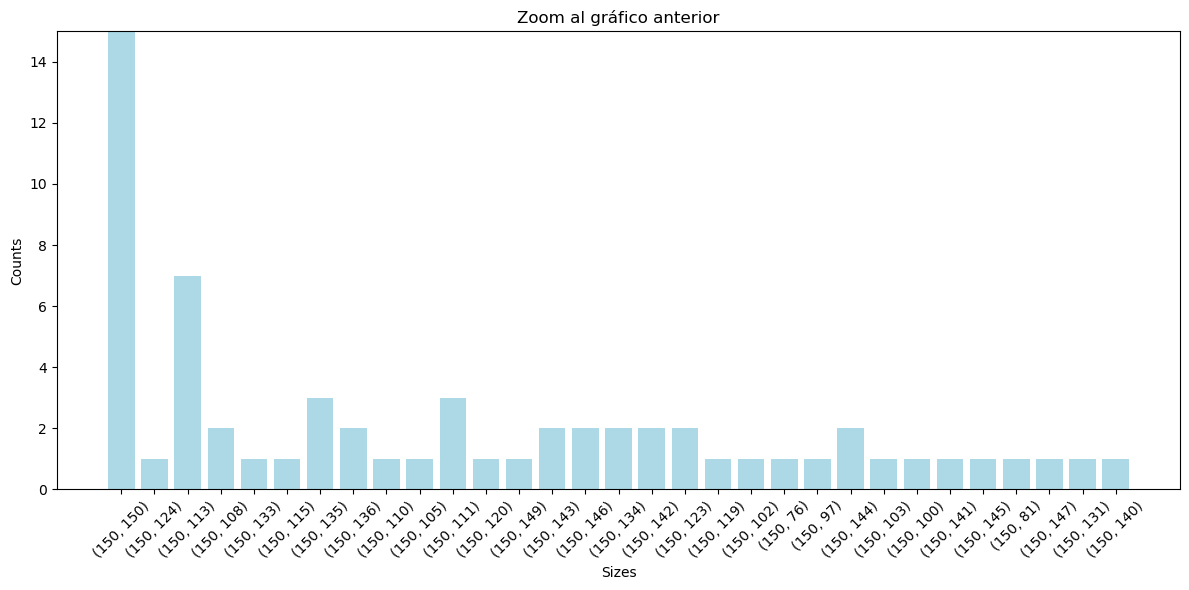

In [3]:
sizes = list(size_distribution.keys())
counts = list(size_distribution.values())

plt.figure(figsize=(12, 6))
plt.bar([str(size) for size in sizes], counts, color='lightblue')
plt.xlabel('Sizes')
plt.ylabel('Counts')
plt.title('Distribucion de tamaño de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar([str(size) for size in sizes], counts, color='lightblue')
plt.xlabel('Sizes')
plt.ylabel('Counts')

plt.ylim(0, 15)
plt.title('Zoom al gráfico anterior')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Estructura y tipo de las imágenes

In [4]:
def show_examples(path, num_classes=5, images_per_class=3):
    classes = random.sample(os.listdir(path), min(num_classes, len(os.listdir(path))))
    fig, axs = plt.subplots(num_classes, images_per_class, figsize=(15, 3*num_classes))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        images = random.sample([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg'))], images_per_class)
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(class_name, loc='left')
    
    plt.tight_layout()
    plt.show()

Clase: buildings, Imagen: 14760.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: forest, Imagen: 10464.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: glacier, Imagen: 5964.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: mountain, Imagen: 3284.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: sea, Imagen: 15821.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: street, Imagen: 16633.jpg, Tamaño: (150, 150), Formato: JPEG


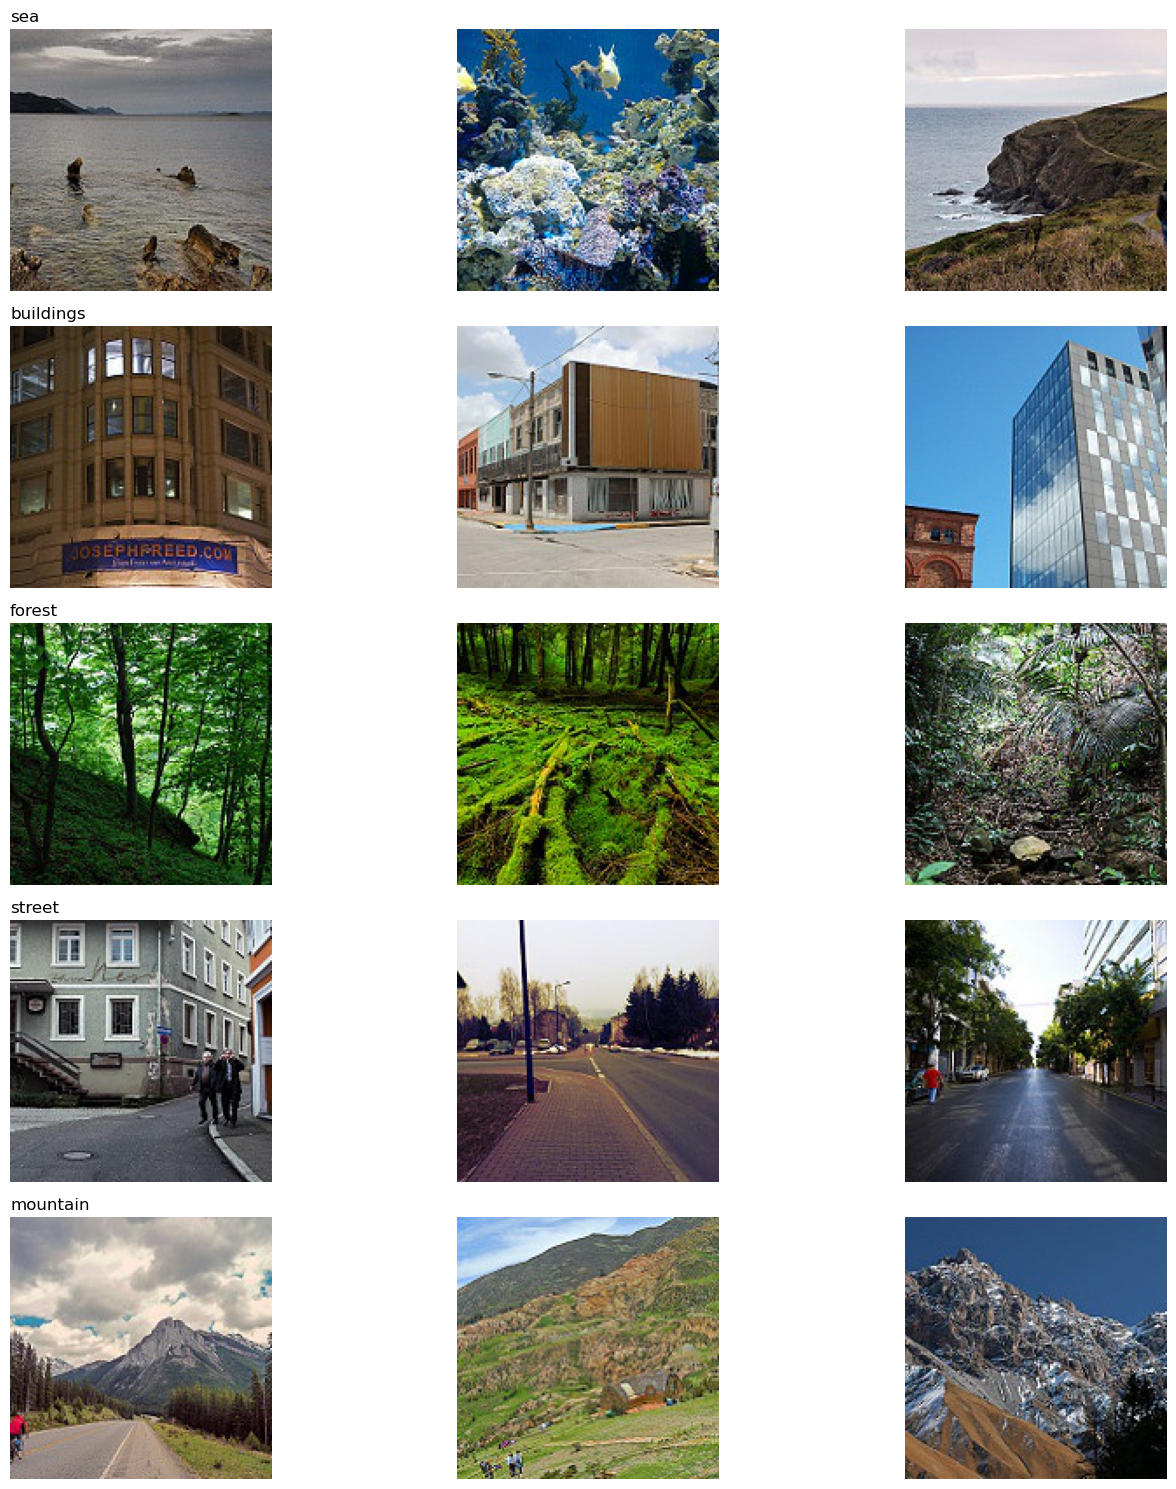

In [5]:
image_sizes = []
image_formats = []
random_images = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    random_image_file = random.choice(image_files)
    random_images.append((class_name, random_image_file))  # Guardar el nombre de la imagen
    image = Image.open(os.path.join(class_path, random_image_file))
    image_sizes.append(image.size)
    image_formats.append(image.format)

for i, (class_name, image_file) in enumerate(random_images):
    print(f"Clase: {class_name}, Imagen: {image_file}, Tamaño: {image_sizes[i]}, Formato: {image_formats[i]}")

show_examples(dataset_path)


## Distribución de la variable a predecir

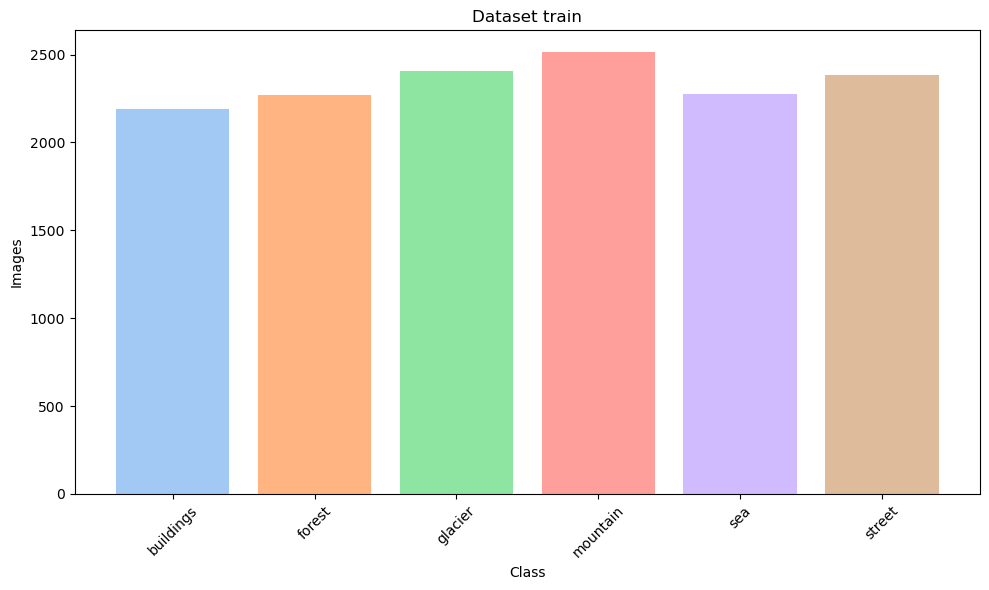

In [6]:
class_counts = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    # Contar el número de archivos de imagen en la carpeta
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

colors = sns.color_palette('pastel', len(classes))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Images')
plt.title('Dataset train')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Modelado

## Comparativa de distintas arquitecturas de redes neuronales (ej: MLP simple y Convolucional, variando cantidad de capas, filtros, etc.).

Lo primero que vamos a hacer es crear datasets de imágenes para Keras, usando sus propias herramientas:

In [7]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    
)

READ_PARAMS = dict(
    class_mode="categorical",  
    classes=TIPO_IMAGEN,  
    target_size=(SIZE, SIZE),  
    color_mode="rgb",  
)

class_names = os.listdir(dataset_path)
image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)  


train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.4,  
    random_state=42,
    stratify=labels  
)


train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    **READ_PARAMS
)


val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    **READ_PARAMS
)

Found 8420 validated image filenames belonging to 6 classes.
Found 5614 validated image filenames belonging to 6 classes.


In [8]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

# MLP SIMPLE

In [9]:
# MLP simple
model = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # O cualquier otra función de pérdida adecuada
    metrics=['accuracy']  # Añadir 'accuracy' aquí
)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               6144500   
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3006      
Total params: 6,147,506
Trainable params: 6,147,506
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

# Entreno

In [13]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 264 steps, validate for 176 steps
Epoch 1/5
264/264 [==============================] - 8s 30ms/step - loss: 2.0470 - accuracy: 0.2399 - val_loss: 1.5904 - val_accuracy: 0.3824
Epoch 2/5
264/264 [==============================] - 7s 28ms/step - loss: 1.7573 - accuracy: 0.2808 - val_loss: 1.6096 - val_accuracy: 0.3285
Epoch 3/5
264/264 [==============================] - 7s 28ms/step - loss: 1.7113 - accuracy: 0.2899 - val_loss: 1.5178 - val_accuracy: 0.3796
Epoch 4/5
264/264 [==============================] - 7s 28ms/step - loss: 1.6738 - accuracy: 0.3023 - val_loss: 1.5081 - val_accuracy: 0.4077
Epoch 5/5
264/264 [==============================] - 7s 28ms/step - loss: 1.6387 - accuracy: 0.3222 - val_loss: 1.4936 - val_accuracy: 0.3767


In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


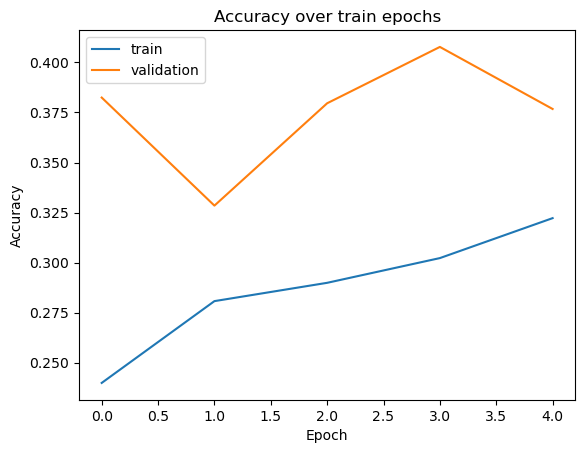

In [15]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# MLP avanzado

In [16]:
# MLP avanzado

#input_shape = (64, 64, 3) #x2 en alto y largo
model = Sequential([
    Input(input_shape), #modifico input shape
    Flatten(),
    Dense(256, activation='relu'), #cambio funcion activacion y menos densidad 
    Dropout(0.35), #Mas dropout
    Dense(256, activation='relu'),#nueva capa
    Dropout(0.4), #Mas dropout
    Dense(1024, activation='relu'),#nueva capa
    Dropout(0.5), #Mas dropout
    Dense(256, activation='relu'),#nueva capa
    Dropout(0.4), #menos dropout
    Dense(256, activation='relu'),#nueva capa
    Dropout(0.4), 
    Dense(256, activation='relu'),#nueva capa
    Dropout(0.4), 
    Dense(256, activation='relu'),#nueva capa
    Dropout(0.4), 
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # O cualquier otra función de pérdida adecuada
    metrics=['accuracy']  # Añadir 'accuracy' aquí
)

model.summary()

# Definir mas callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)

history = model.fit(
    train_generator,
    epochs=20, # Número de épocas
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3145984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

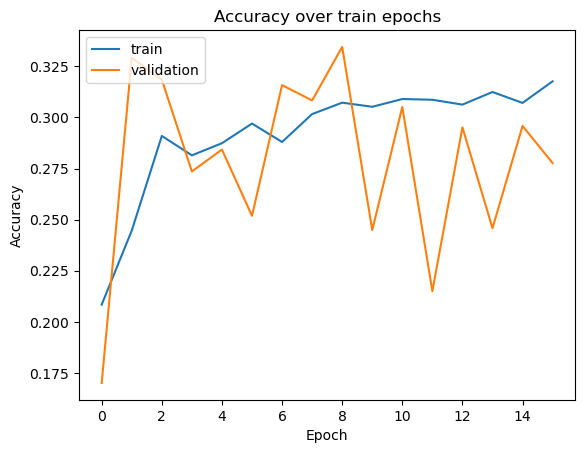

In [17]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Convolucional simple

In [18]:
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 10)        490       
_________________________________________________________________
dropout_8 (Dropout)          (None, 61, 61, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 10)        1610      
_________________________________________________________________
dropout_9 (Dropout)          (None, 58, 58, 10)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)              

In [29]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/5
264/264 [==============================] - 8s 29ms/step - loss: 1.7979 - accuracy: 0.1631 - val_loss: 1.8009 - val_accuracy: 0.1621
Epoch 2/5
264/264 [==============================] - 8s 29ms/step - loss: 1.8009 - accuracy: 0.1660 - val_loss: 1.7971 - val_accuracy: 0.1714
Epoch 3/5
264/264 [==============================] - 8s 29ms/step - loss: 1.8011 - accuracy: 0.1660 - val_loss: 1.8077 - val_accuracy: 0.1621
Epoch 4/5
264/264 [==============================] - 8s 30ms/step - loss: 1.7991 - accuracy: 0.1673 - val_loss: 1.7954 - val_accuracy: 0.1560
Epoch 5/5
264/264 [==============================] - 8s 29ms/step - loss: 1.8025 - accuracy: 0.1686 - val_loss: 1.8055 - val_accuracy: 0.1621


ERROR! Session/line number was not unique in database. History logging moved to new session 61


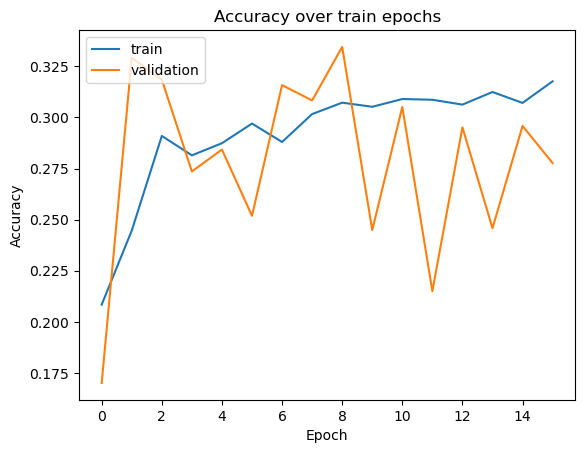

In [21]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Convolucionales avanzadas

In [22]:
#V1 mas capas y epocas
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])



model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

model.summary()

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 61, 61, 10)        490       
_________________________________________________________________
dropout_11 (Dropout)         (None, 61, 61, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 10)        1610      
_________________________________________________________________
dropout_12 (Dropout)         (None, 58, 58, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/10
264/264 [==============================] - 8s 30ms/step - loss: 1.8000 - accuracy: 0.1696 - val_loss: 2.4267 - val_accuracy: 0.1665
Epoch 2/10
264/264 [==============================] - 7s 28ms/step - loss: 1.9654 - accuracy: 0.1748 - val_loss: 1.8094 - val_accuracy: 0.1774
Epoch 3/10
264/264 [==============================] - 7s 28ms/step - loss: 1.8824 - accuracy: 0.1703 - val_loss: 1.8101 - val_accuracy: 0.1703
Epoch 4/10
264/264 [==============================] - 7s 28ms/step - loss: 1.8545 - accuracy: 0.1709 - val_loss: 1.8052 - val_accuracy: 0.1733
Epoch 5/10
264/264 [==============================] - 7s 28ms/step - loss: 1.8276 - accuracy: 0.1709 - val_loss: 1.7949 - val_accuracy: 0.1682
Epoch 6/10
264/264 [==============================] - 7s 28ms/step - loss: 1.8206 - accuracy: 0.1656 - val_loss: 1.7944 - val_accuracy: 0.1703
Epoch 7/10
264/264 [==============================] - 7s 28ms/step - loss: 1.8129 - accuracy: 0.17

In [35]:
#V2 callbacks, binary_crossentropy, mas capas

model = Sequential([
    Input(input_shape),

    Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Añadimos una capa más para una extracción más profunda de características
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #Cambiamos
    metrics=['accuracy',],
)

model.summary()

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)      

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/10
264/264 [==============================] - 9s 33ms/step - loss: 0.4505 - accuracy: 0.8333 - val_loss: 0.4709 - val_accuracy: 0.8333
Epoch 2/10
264/264 [==============================] - 8s 29ms/step - loss: 0.4585 - accuracy: 0.8333 - val_loss: 3.5823 - val_accuracy: 0.7233
Epoch 3/10
264/264 [==============================] - 8s 29ms/step - loss: 0.4632 - accuracy: 0.8333 - val_loss: 4.0274 - val_accuracy: 0.7233
Epoch 4/10
264/264 [==============================] - 8s 29ms/step - loss: 0.4632 - accuracy: 0.8333 - val_loss: 3.9516 - val_accuracy: 0.7233
Epoch 5/10
264/264 [==============================] - 8s 29ms/step - loss: 0.4680 - accuracy: 0.8333 - val_loss: 2.6882 - val_accuracy: 0.7263
Epoch 6/10
264/264 [==============================] - 8s 29ms/step - loss: 0.4636 - accuracy: 0.8333 - val_loss: 2.7347 - val_accuracy: 0.7263
Epoch 7/10
264/264 [==============================] - 8s 29ms/step - loss: 0.4573 - accuracy: 0.83

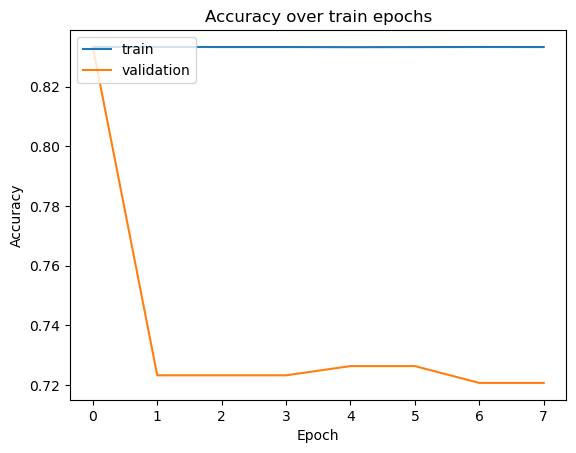

In [36]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 62
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 61, 61, 10)        490       
_________________________________________________________________
dropout_33 (Dropout)         (None, 61, 61, 10)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 58, 58, 10)        1610      
_________________________________________________________________
dropout_34 (Dropout)         (None, 58, 58, 10)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1960)              0         
________________________

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/20
264/264 [==============================] - 8s 30ms/step - loss: 0.5095 - accuracy: 0.8170 - val_loss: 0.4525 - val_accuracy: 0.8333
Epoch 2/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4918 - accuracy: 0.8251 - val_loss: 0.4545 - val_accuracy: 0.8333
Epoch 3/20
264/264 [==============================] - 8s 28ms/step - loss: 0.4742 - accuracy: 0.8317 - val_loss: 0.4531 - val_accuracy: 0.8333
Epoch 4/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4670 - accuracy: 0.8332 - val_loss: 0.4516 - val_accuracy: 0.8333
Epoch 5/20
264/264 [==============================] - 7s 28ms/step - loss: 0.4614 - accuracy: 0.8333 - val_loss: 0.4531 - val_accuracy: 0.8333
Epoch 6/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4572 - accuracy: 0.8333 - val_loss: 0.4539 - val_accuracy: 0.8333
Epoch 7/20
264/264 [==============================] - 7s 28ms/step - loss: 0.4562 - accuracy: 0.83

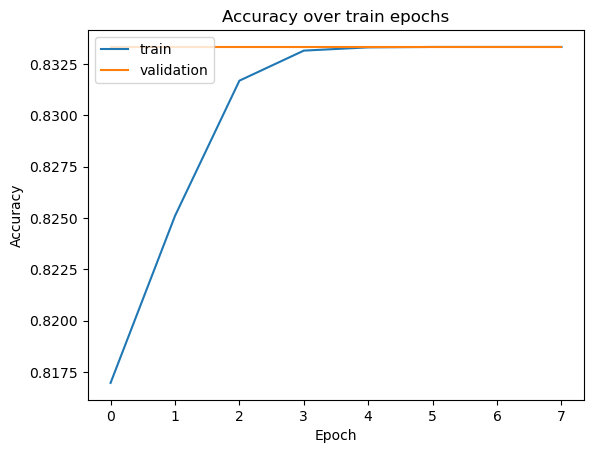

In [37]:
#V3 menos capas, mas epocas, mas dropout
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.3),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.3),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])



# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #Cambiamos
    metrics=['accuracy',],
)

model.summary()

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 61, 61, 10)        490       
_________________________________________________________________
dropout_36 (Dropout)         (None, 61, 61, 10)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 58, 58, 10)        1610      
_________________________________________________________________
dropout_37 (Dropout)         (None, 58, 58, 10)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 54, 54, 20)        5020      
_________________________________________________________________
dropout_38 (Dropout)         (None, 54, 54, 20)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 52, 15)      

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/20
264/264 [==============================] - 8s 32ms/step - loss: 0.4609 - accuracy: 0.8299 - val_loss: 0.5101 - val_accuracy: 0.8201
Epoch 2/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4594 - accuracy: 0.8308 - val_loss: 0.4771 - val_accuracy: 0.8302
Epoch 3/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4558 - accuracy: 0.8318 - val_loss: 0.4852 - val_accuracy: 0.8299
Epoch 4/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4556 - accuracy: 0.8325 - val_loss: 0.4988 - val_accuracy: 0.8293
Epoch 5/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4549 - accuracy: 0.8328 - val_loss: 0.4677 - val_accuracy: 0.8333
Epoch 6/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4546 - accuracy: 0.8328 - val_loss: 0.4657 - val_accuracy: 0.8333
Epoch 7/20
264/264 [==============================] - 8s 29ms/step - loss: 0.4547 - accuracy: 0.83

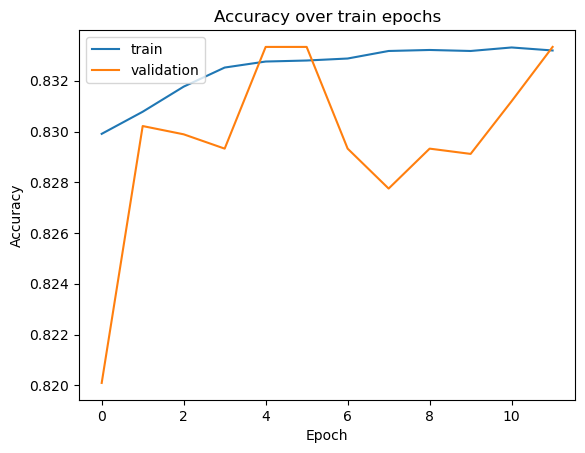

In [38]:
#V4 menos capas, mas epocas, mas dropout, mas capas
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.3),
    
    Convolution2D(filters=20, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.3),
    
    Convolution2D(filters=15, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.3),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.3),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])



# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #Cambiamos
    metrics=['accuracy',],
)

model.summary()

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Convolucional usando convoluciones ya entrenadas de VGG16

In [23]:
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 606       
Total params: 14,930,294
Trainable params: 215,606
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/5
264/264 [==============================] - 9s 34ms/step - loss: 1.8289 - accuracy: 0.1637 - val_loss: 1.8079 - val_accuracy: 0.1621
Epoch 2/5
264/264 [==============================] - 7s 28ms/step - loss: 1.8060 - accuracy: 0.1638 - val_loss: 1.8113 - val_accuracy: 0.1714
Epoch 3/5
264/264 [==============================] - 8s 28ms/step - loss: 1.8036 - accuracy: 0.1627 - val_loss: 1.7939 - val_accuracy: 0.1698
Epoch 4/5
264/264 [==============================] - 8s 29ms/step - loss: 1.8014 - accuracy: 0.1659 - val_loss: 1.8124 - val_accuracy: 0.1714
Epoch 5/5
264/264 [==============================] - 8s 29ms/step - loss: 1.8023 - accuracy: 0.1673 - val_loss: 1.7923 - val_accuracy: 0.1617


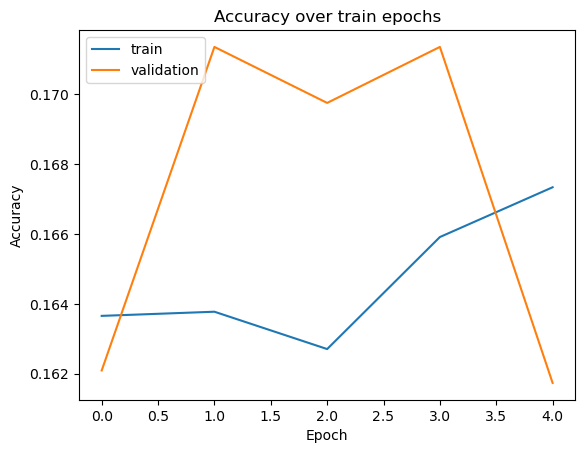

In [27]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Mas versiones

ERROR! Session/line number was not unique in database. History logging moved to new session 64
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 606       
Total params: 14,930,294
Trainable params: 215,606
Non-trainable params: 14,714,688
_________________________________________________________________
  ...


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/5
264/264 [==============================] - 8s 32ms/step - loss: 0.4573 - accuracy: 0.8330 - val_loss: 0.4518 - val_accuracy: 0.8333
Epoch 2/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4534 - accuracy: 0.8333 - val_loss: 0.4551 - val_accuracy: 0.8333
Epoch 3/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4530 - accuracy: 0.8333 - val_loss: 0.4522 - val_accuracy: 0.8333
Epoch 4/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4523 - accuracy: 0.8333 - val_loss: 0.4516 - val_accuracy: 0.8333
Epoch 5/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4524 - accuracy: 0.8333 - val_loss: 0.4520 - val_accuracy: 0.8333


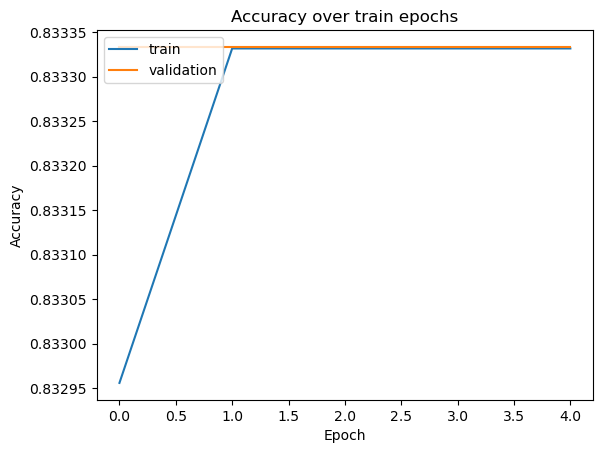

In [40]:
#V2, binary crossentropy
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

model.summary()


history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_36 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 606       
Total params: 14,930,294
Trainable params: 215,606
Non-trainable params: 14,714,688
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/5
264/264 [==============================] - 8s 31ms/step - loss: 0.4564 - accuracy: 0.8329 - val_loss: 0.4548 - val_accuracy: 0.8333
Epoch 2/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4539 - accuracy: 0.8333 - val_loss: 0.4543 - val_accuracy: 0.8333
Epoch 3/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4530 - accuracy: 0.8333 - val_loss: 0.4523 - val_accuracy: 0.8333
Epoch 4/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4528 - accuracy: 0.8333 - val_loss: 0.4516 - val_accuracy: 0.8333
Epoch 5/5
264/264 [==============================] - 8s 29ms/step - loss: 0.4520 - accuracy: 0.8333 - val_loss: 0.4523 - val_accuracy: 0.8333


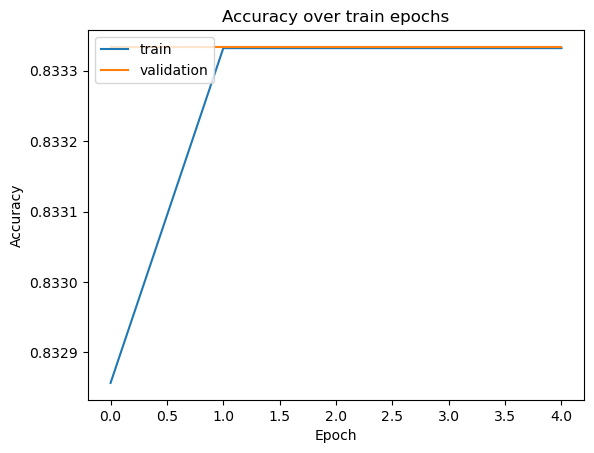

In [41]:
#V3, callbacks
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)


history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 606       
Total params: 14,930,294
Trainable params: 215,606
Non-trainable params: 14,714,688
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/15
264/264 [==============================] - 9s 32ms/step - loss: 0.5321 - accuracy: 0.8127 - val_loss: 0.4505 - val_accuracy: 0.8333
Epoch 2/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4505 - accuracy: 0.8333 - val_loss: 0.4504 - val_accuracy: 0.8333
Epoch 3/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4504 - accuracy: 0.8333 - val_loss: 0.4504 - val_accuracy: 0.8333
Epoch 4/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4504 - accuracy: 0.8333 - val_loss: 0.4504 - val_accuracy: 0.8333
Epoch 5/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4504 - accuracy: 0.8333 - val_loss: 0.4504 - val_accuracy: 0.8333
Epoch 6/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4504 - accuracy: 0.8333 - val_loss: 0.4504 - val_accuracy: 0.8333


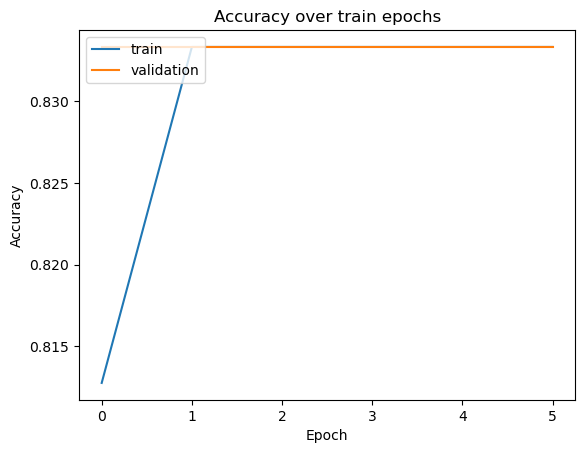

In [42]:
#V4, activation distinto
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)


history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 65
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
________________________

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/15
264/264 [==============================] - 9s 32ms/step - loss: 0.4545 - accuracy: 0.8327 - val_loss: 0.4568 - val_accuracy: 0.8332
Epoch 2/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4505 - accuracy: 0.8333 - val_loss: 0.4628 - val_accuracy: 0.8332
Epoch 3/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4514 - accuracy: 0.8332 - val_loss: 0.4634 - val_accuracy: 0.8332
Epoch 4/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4505 - accuracy: 0.8333 - val_loss: 0.4634 - val_accuracy: 0.8332
Epoch 5/15
264/264 [==============================] - 8s 29ms/step - loss: 0.4505 - accuracy: 0.8333 - val_loss: 0.4634 - val_accuracy: 0.8332
Epoch 6/15
264/264 [==============================] - 8s 30ms/step - loss: 0.4505 - accuracy: 0.8333 - val_loss: 0.4634 - val_accuracy: 0.8332


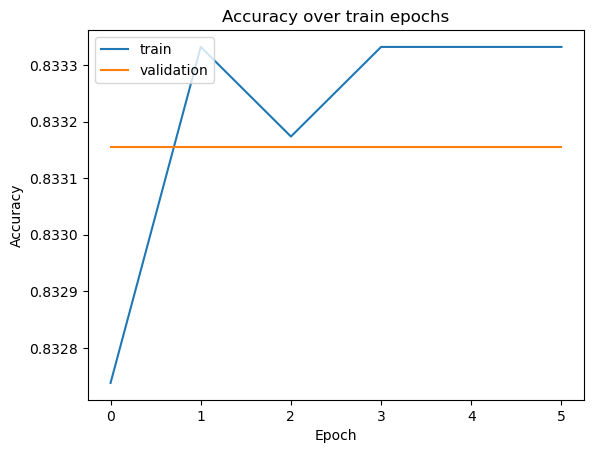

In [43]:
#V5, mas capas y droput
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(150, activation='relu'),
    Dropout(0.3),
    Dense(150, activation='relu'),
    Dropout(0.3),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)


history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 157
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________________________

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/15
264/264 [==============================] - 39s 148ms/step - loss: 0.2391 - accuracy: 0.8994 - val_loss: 0.1698 - val_accuracy: 0.9313
Epoch 2/15
264/264 [==============================] - 23s 87ms/step - loss: 0.1736 - accuracy: 0.9319 - val_loss: 0.1542 - val_accuracy: 0.9374
Epoch 3/15
264/264 [==============================] - 20s 76ms/step - loss: 0.1540 - accuracy: 0.9390 - val_loss: 0.1510 - val_accuracy: 0.9382
Epoch 4/15
264/264 [==============================] - 14s 54ms/step - loss: 0.1435 - accuracy: 0.9444 - val_loss: 0.1558 - val_accuracy: 0.9377
Epoch 5/15
264/264 [==============================] - 14s 54ms/step - loss: 0.1346 - accuracy: 0.9481 - val_loss: 0.1455 - val_accuracy: 0.9426
Epoch 6/15
264/264 [==============================] - 14s 53ms/step - loss: 0.1285 - accuracy: 0.9501 - val_loss: 0.1557 - val_accuracy: 0.9387
Epoch 7/15
264/264 [==============================] - 14s 53ms/step - loss: 0.1216 - accura

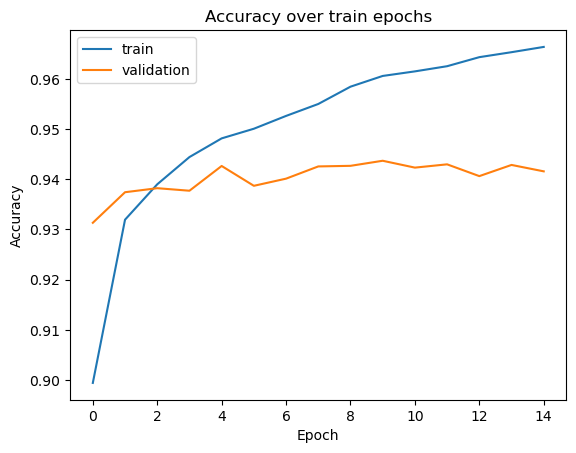

In [9]:
#V5, capas originales + droput
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dropout(0.3),
        
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)


history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/35
264/264 [==============================] - 32s 122ms/step - loss: 0.2388 - accuracy: 0.9006 - val_loss: 0.1642 - val_accuracy: 0.9337
Epoch 2/35
264/264 [==============================] - 30s 114ms/step - loss: 0.1713 - accuracy: 0.9317 - val_loss: 0.1561 - val_accuracy: 0.9344
Epoch 3/35
264/264 [==============================] - 26s 100ms/step - loss: 0.1560 - accuracy: 0.9374 - val_loss: 0.1556 - val_accuracy: 0.9369
Epoch 4/35
264/264 [==============================] - 31s 118ms/step - loss: 0.1413 - accuracy: 0.9447 - val_loss: 0.1443 - val_accuracy: 0.9435
Epoch 5/35
264/264 [==============================] - 29s 109ms/step - loss: 0.1356 - accuracy: 0.9472 - val_loss: 0.1435 - val_accuracy: 0.9428
Epoch 6/35
264/264 [==============================] - 31s 118ms/step - loss: 0.1270 - accuracy: 0.9499 - val_loss: 0.1480 - val_accuracy: 0.9413
Epoch 7/35
264/264 [==============================] - 31s 119ms/step - loss: 0.1230 - 

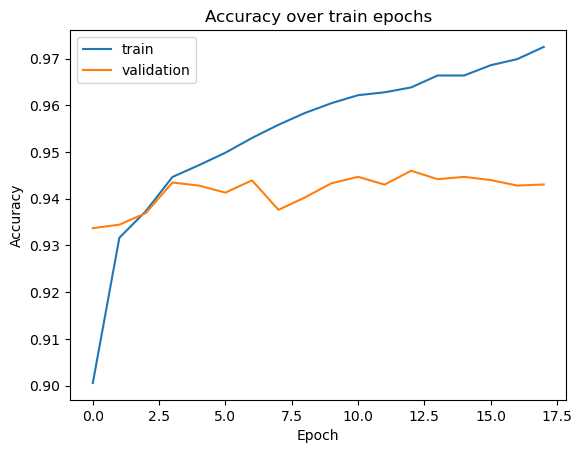

In [19]:
#V5, capas originales + droput
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dropout(0.3),
        
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)


history = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]
)

# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 3. Conclusiones

# MLP

Conclusion MLP

# Convolucionales

Conclusion 

# Salida CSV

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Directorio de imágenes de prueba
test_image_folder = TEST_DIR
output_csv_path = "predicciones.csv"

# Listar las imágenes a predecir
image_filenames = [img for img in os.listdir(test_image_folder) if img.endswith(".jpg") or img.endswith(".png")]

# Almacenar predicciones
predictions = []

for img_name in image_filenames:
    # Cargar y preprocesar la imagen
    img_path = os.path.join(test_image_folder, img_name)
    img = load_img(img_path, target_size=(SIZE, SIZE))
    img_array = img_to_array(img) / 255.0  # Normalizar la imagen
    img_array = img_array.reshape((1,) + img_array.shape)  # Añadir dimensión batch

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_label = TIPO_IMAGEN[prediction.argmax()]  # Obtener la clase predicha

    # Agregar a la lista de predicciones
    predictions.append({"ID": img_name, "Label": predicted_label})

# Crear el DataFrame y guardar como CSV
df = pd.DataFrame(predictions)
df.to_csv(output_csv_path, index=False)
print(f"Archivo CSV guardado en: {output_csv_path}")
